In [70]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


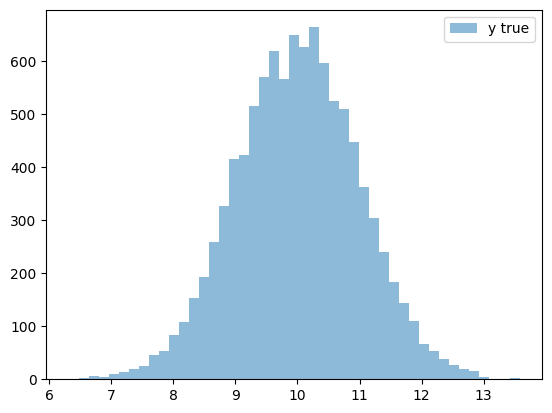

In [71]:
S=1
scale = 1
means = [10]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

T=10000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))


plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=45, label='y true')
plt.legend()

In [72]:
mean_10 = scipy.stats.norm(loc=10, scale=1)

Theta gradient calculation
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y^m)$$
$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y^m)$$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m)^2 - 10 y^m $$

Text(0.5, 1.0, 'Histogram of $\\nabla_\\phi \\theta$ over T trials, mean:1.02, T=10000, M=2')

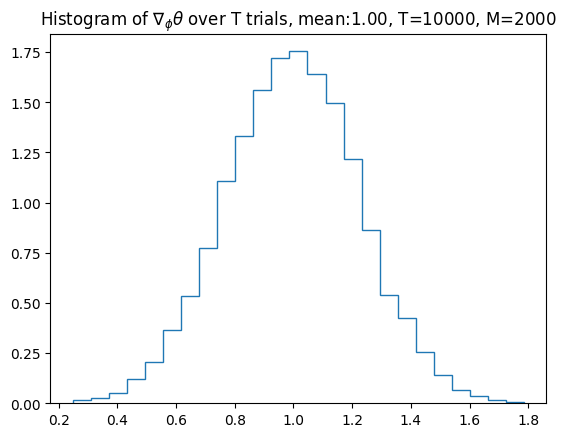

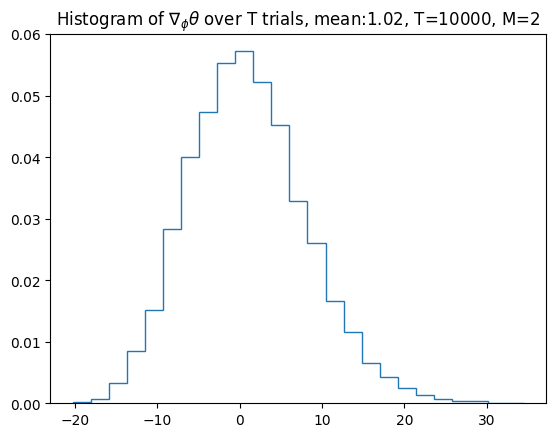

In [73]:
M=2000
samples_TM_2k = mean_10.rvs(size=(T,M), random_state=rng)
theta_gradient_TM_2k = (samples_TM_2k-10)*samples_TM_2k
theta_gradient_T_2k = tf.reduce_mean(theta_gradient_TM_2k, axis=1)    
plt.figure()
plt.hist(theta_gradient_T_2k, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi \theta$ over T trials, mean:{np.mean(theta_gradient_T_2k):.2f}, T={T}, M={M}')

M=2
samples_TM_2 = mean_10.rvs(size=(T,M), random_state=rng)
theta_gradient_TM_2 = (samples_TM_2-10)*samples_TM_2
theta_gradient_T_2 = tf.reduce_mean(theta_gradient_TM_2, axis=1)    
plt.figure()
plt.hist(theta_gradient_T_2, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi \theta$ over T trials, mean:{np.mean(theta_gradient_T_2):.2f}, T={T}, M={M}')

makes sense that this is skewed, $x^2-10x$ is a parabola so $|x^2-10x|_{x=11}> |x^2-10x|_{x=9}$

Loss Gradient calculation
 $$\nabla_\theta  \mathcal{L}(\theta_t, y_t) =  \nabla_\theta   (y_t-\theta_t)^2$$

 $$ = -2(y_t-\theta_t)$$
 $$ = -2(y_t - \frac{1}{M}\sum_{m=1}^M y^m)$$

In [74]:
expected_actions_T_2k_reuse = tf.reduce_mean(samples_TM_2k, axis=1)
grad_L_wrt_theta_T_2k_reuse = -2.0*(tf.squeeze(y_TS)-expected_actions_T_2k_reuse)

expected_actions_T_2_reuse = tf.reduce_mean(samples_TM_2, axis=1)
grad_L_wrt_theta_T_2_reuse = -2.0*(tf.squeeze(y_TS)-expected_actions_T_2_reuse)

samples_TM_2k_for_loss = mean_10.rvs(size=(T,2000), random_state=rng)
expected_actions_T_2k_fresh = tf.reduce_mean(samples_TM_2k_for_loss, axis=1)
grad_L_wrt_theta_T_2k_fresh = -2.0*(tf.squeeze(y_TS)-expected_actions_T_2k_fresh)

samples_TM_2_for_loss = mean_10.rvs(size=(T,2), random_state=rng)
expected_actions_T_2_fresh = tf.reduce_mean(samples_TM_2_for_loss, axis=1)
grad_L_wrt_theta_T_2_fresh = -2.0*(tf.squeeze(y_TS)-expected_actions_T_2_fresh)

Text(0.5, 1.0, 'Histogram of $\\nabla_\\theta L$ over T trials, mean:-0.00, T=10000, M=2')

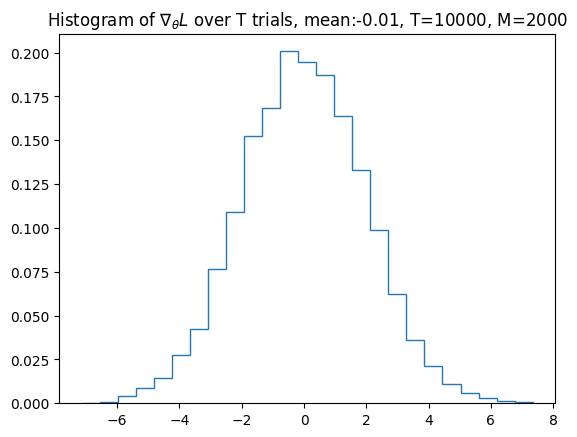

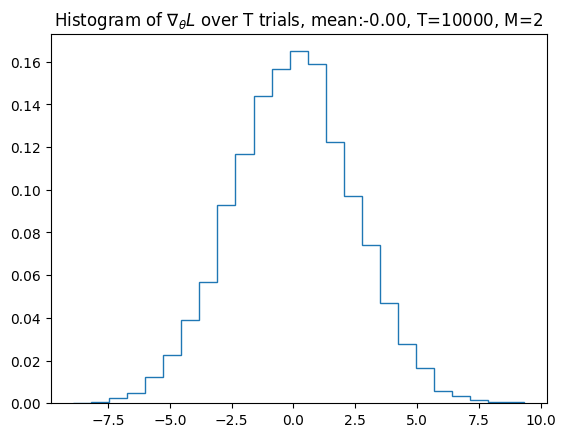

In [75]:
plt.figure()
plt.hist(grad_L_wrt_theta_T_2k_reuse, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\theta L$ over T trials, mean:{np.mean(grad_L_wrt_theta_T_2k_reuse):.2f}, T={T}, M=2000')

plt.figure()
plt.hist(grad_L_wrt_theta_T_2_reuse, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\theta L$ over T trials, mean:{np.mean(grad_L_wrt_theta_T_2_reuse):.2f}, T={T}, M=2')

Roughly the same, this doesnt depend on the samples

Finally, the overall gradient
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$


In [76]:
overall_gradient_T_2k_reuse = theta_gradient_T_2k * grad_L_wrt_theta_T_2k_reuse
overall_gradient_T_2_reuse = theta_gradient_T_2 * grad_L_wrt_theta_T_2_reuse
overall_gradient_T_2k_fresh = theta_gradient_T_2k * grad_L_wrt_theta_T_2k_fresh
overall_gradient_T_2_fresh = theta_gradient_T_2 * grad_L_wrt_theta_T_2_fresh

Text(0.5, 1.0, 'Histogram of $\\nabla_\\phi L$ over T trials, fresh samples, mean:-0.07, T=10000, M=2')

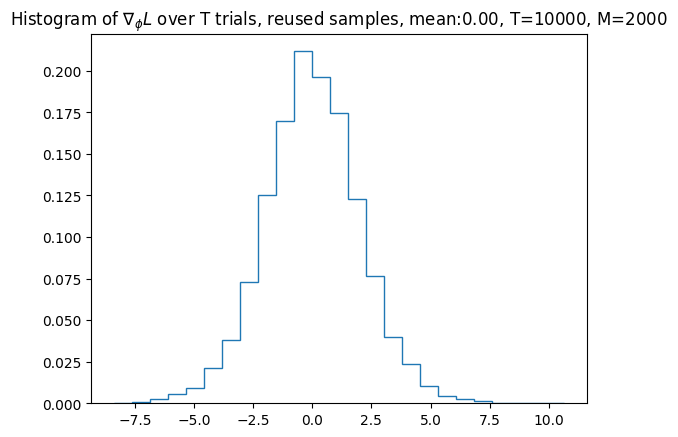

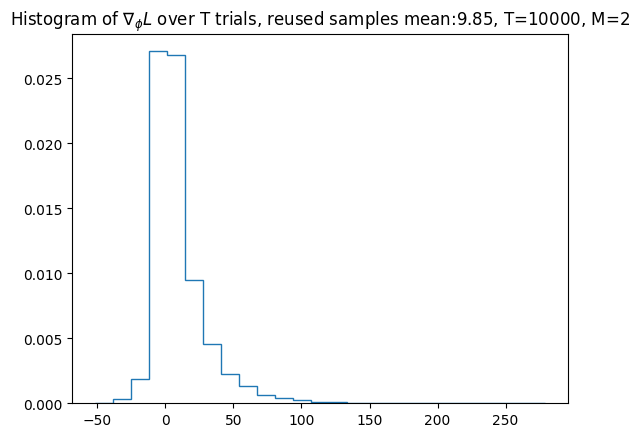

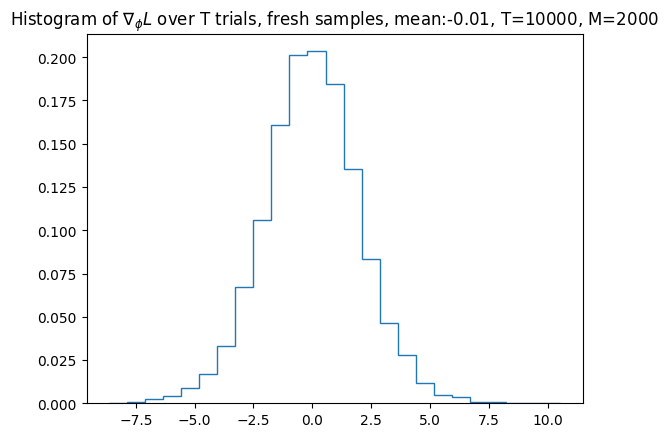

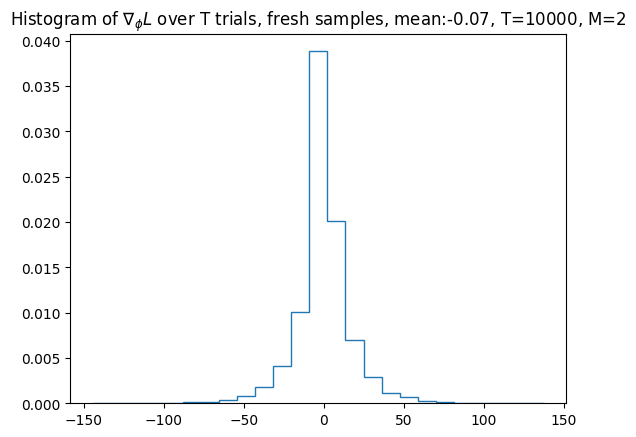

In [77]:
plt.figure()
plt.hist(overall_gradient_T_2k_reuse, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi L$ over T trials, reused samples, mean:{np.mean(overall_gradient_T_2k_reuse):.2f}, T={T}, M=2000')

plt.figure()
plt.hist(overall_gradient_T_2_reuse, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi L$ over T trials, reused samples mean:{np.mean(overall_gradient_T_2_reuse):.2f}, T={T}, M=2')

plt.figure()
plt.hist(overall_gradient_T_2k_fresh, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi L$ over T trials, fresh samples, mean:{np.mean(overall_gradient_T_2k_fresh):.2f}, T={T}, M=2000')

plt.figure()
plt.hist(overall_gradient_T_2_fresh, bins=25, histtype='step', density=True)
plt.title(rf'Histogram of $\nabla_\phi L$ over T trials, fresh samples, mean:{np.mean(overall_gradient_T_2_fresh):.2f}, T={T}, M=2')
